# Asset Allocation with Pytorch

 Goal of this notebook is to create a model to combine the signals from the various strategies to create an asset allocation neural network to outperform equally weighted, as Markowitz may not be appropriate as the signals may be to buy or sell the same asset therefore yielding a perfect correlation when active.

In [1]:
from loguru import logger
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import typing as t

C:\Users\tomw1\AppData\Local\Temp\ipykernel_9016\708485070.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from quantified_strategies import utils

In [3]:
ASSETS = ["SPY"]
ASSETS

['SPY']

## Dataset Collection

In [56]:
def get_data(assets: str | t.List[str], is_classification: bool = True) -> t.Tuple[pd.DataFrame, pd.DataFrame]:

    def get_y() -> pd.DataFrame:
        price_data = [utils.get_data(ticker=ticker, columns="Adj Close").to_frame(name=ticker) for ticker in assets if ticker != "CASH"]
        price_data = pd.concat(price_data, axis=1)
        return_data = price_data.pct_change()
        if "CASH" in assets:
            return_data["CASH"] = 0.0
        return_data = return_data.shift(-1)

        if is_classification:
            return (return_data > 0).astype(int)
        
        return return_data

    def get_X() -> pd.DataFrame:
        strategy_returns = pd.read_csv(f"outputs/strategy_returns.csv", index_col=0, header=[0, 1, 2])
        strategy_returns = strategy_returns.loc[:, strategy_returns.columns.get_level_values(2).isin(assets)]
        strategy_returns.index = pd.DatetimeIndex(strategy_returns.index)
        is_active = ~(strategy_returns.isna())
        is_active = is_active.astype(int)
        return is_active

    assets = assets if isinstance(assets, list) else [assets]

    # Get target variables: these are the returns from entering a position from close to close t+1
    y = get_y()
    
    # Get explanatory variables: these are the signals from the strategies indicating whether to buy or not
    X = get_X()

    X = X.loc[X.index.isin(X.index.intersection(y.index))]
    y = y.loc[y.index.isin(y.index.intersection(X.index))]

    X = X.sort_index()
    y = y.sort_index()

    return X, y

X_total, y_total = get_data(assets=ASSETS, is_classification=False)

In [57]:
# new_col = y_total + pd.DataFrame({"SPY": np.random.normal(loc=0.0, scale=0.66, size=X_total.shape[0])}, index=y_total.index)
# X_total["cheat"] = new_col

In [58]:
print(f"{X_total.shape = }")
print(f"{y_total.shape = }")

X_total.shape = (3556, 8)
y_total.shape = (3556, 1)


In [59]:
X_total.head(1)

event_trading   overnight_trading        seasonal_trading  \
              super_bowl short_term_reversal buy_when_yields_are_low   
                     SPY                 SPY                     SPY   
Date                                                                   
2010-01-04             0                   0                       0   

                                                                 \
           pay_day_strategy santa_claus_strategy september_bear   
                        SPY                  SPY            SPY   
Date                                                              
2010-01-04                0                    1              0   

                                                          
           tax_day_strategy turn_around_tuesday_strategy  
                        SPY                          SPY  
Date                                                      
2010-01-04                0                            0

In [60]:
y_total.head(1)

,SPY
Date,
2010-01-04,0.002647


In [61]:
assert X_total.dropna().shape[0] == X_total.shape[0]
assert y_total.dropna().shape[0] == y_total.shape[0]

In [62]:
def encode(x):
    return sum([x_ * 10 ** i for i, x_ in enumerate(x)])

changes = X_total.apply(lambda x: encode(x.values), axis=1)
changes = changes.diff().fillna(1.0)
changes = changes[changes != 0.0]
changes

Date
2010-01-04           1.0
2010-01-08       -9900.0
2010-01-22          10.0
2010-01-25         990.0
2010-02-02       -1000.0
                 ...    
2024-02-07   -10000000.0
2024-02-08        -100.0
2024-02-12    10000001.0
2024-02-14   -10000000.0
2024-02-16          -1.0
Length: 1143, dtype: float64

In [63]:
X_total = X_total.loc[X_total.index.isin(changes.index)]
X_total

event_trading   overnight_trading        seasonal_trading  \
              super_bowl short_term_reversal buy_when_yields_are_low   
                     SPY                 SPY                     SPY   
Date                                                                   
2010-01-04             0                   0                       0   
2010-01-08             0                   0                       1   
2010-01-22             0                   1                       1   
2010-01-25             0                   0                       1   
2010-02-02             0                   0                       1   
...                  ...                 ...                     ...   
2024-02-07             0                   0                       1   
2024-02-08             0                   0                       0   
2024-02-12             1                   0                       0   
2024-02-14             1                   0                       0   
2024-02-16             0                   0                       0   

                                                                 \
           pay_day_strategy santa_claus_strategy september_bear   
                        SPY                  SPY            SPY   
Date                                                              
2010-01-04                0                    1              0   
2010-01-08                0                    0              0   
2010-01-22                0                    0              0   
2010-01-25                1                    0              0   
2010-02-02                0                    0              0   
...                     ...                  ...            ...   
2024-02-07                0                    0              0   
2024-02-08                0                    0              0   
2024-02-12                0                    0              0   
2024-02-14                0                    0              0   
2024-02-16                0                    0              0   

                                                          
           tax_day_strategy turn_around_tuesday_strategy  
                        SPY                          SPY  
Date                                                      
2010-01-04                0                            0  
2010-01-08                0                            0  
2010-01-22                0                            0  
2010-01-25                0                            0  
2010-02-02                0                            0  
...                     ...                          ...  
2024-02-07                0                            0  
2024-02-08                0                            0  
2024-02-12                0                            1  
2024-02-14                0                            0  
2024-02-16                0                            0  

[1143 rows x 8 columns]

In [64]:
y_copy = y_total.copy()
y_copy = pd.concat([y_copy, pd.DataFrame(1, columns=["change_in_X"], index=X_total.index)], axis=1)
y_copy = y_copy.fillna(0.0)
y_copy["cum_change_in_X"] = y_copy["change_in_X"].cumsum()
y_copy = y_copy.groupby("cum_change_in_X")[ASSETS].apply(lambda x: (1 + x).prod() - 1, include_groups=False)
y_copy.index = X_total.index
# y_copy = (y_copy > 0).astype(int)
y_copy

,SPY
Date,
2010-01-04,0.010942
2010-01-08,-0.046784
2010-01-22,0.005127
2010-01-25,0.005557
2010-02-02,-0.040677
...,...
2024-02-07,0.000442
2024-02-08,0.005338
2024-02-12,-0.004811


In [65]:
y_total = y_copy.copy()
y_total

,SPY
Date,
2010-01-04,0.010942
2010-01-08,-0.046784
2010-01-22,0.005127
2010-01-25,0.005557
2010-02-02,-0.040677
...,...
2024-02-07,0.000442
2024-02-08,0.005338
2024-02-12,-0.004811


## Create Pytorch Model

In [66]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

In [67]:
def get_device() -> torch.device:

    if torch.cuda.is_available():
        logger.info("Running on the GPU")
        n_gpu = 0 # different if you have more than 1
        assert n_gpu <= (torch.cuda.device_count() - 1)
        logger.info(f"Using gpu={n_gpu} out of {torch.cuda.device_count()}")
        device = torch.device(f"cuda:{n_gpu}")
    else:
        logger.info("Running on the CPU")
        device = torch.device("cpu")
    
    return device

DEVICE = get_device()
DEVICE

2024-02-22 10:22:06.766 | INFO     | __main__:get_device:10 - Running on the CPU


device(type='cpu')

In [68]:
class Net(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()

        self.input_shape: int = input_shape
        self.output_shape: int = output_shape
        
        self.fc1 = nn.Linear(in_features=input_shape, out_features=8)
        self.fc2 = nn.Linear(in_features=8, out_features=16)
        self.fc3 = nn.Linear(in_features=16, out_features=8)
        self.fc_output = nn.Linear(in_features=8, out_features=output_shape)
        
    
    def forward(self, x):

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.relu(x)

        x = self.fc_output(x)
        # output = F.sigmoid(x)
        output = F.tanh(x)

        return output


In [69]:
net = Net(input_shape=X_total.shape[1], output_shape=y_total.shape[1]).to(device=DEVICE)
net

Net(
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (fc_output): Linear(in_features=8, out_features=1, bias=True)
)

In [70]:
input_shape = net.input_shape
example = torch.randn(input_shape).view(-1, input_shape)
print(f"{example.shape = }")
net.forward(x=example)

example.shape = torch.Size([1, 8])


tensor([[-0.3187]], grad_fn=<TanhBackward0>)

In [71]:
def convert_data_to_tensors(X: pd.DataFrame, y: pd.DataFrame) -> t.Tuple[torch.Tensor, torch.Tensor]:    
    X_tensor = torch.Tensor(X.values) if isinstance(X, pd.DataFrame) else X
    y_tensor = torch.Tensor(y.values) if isinstance(y, pd.DataFrame) else y
    return X_tensor, y_tensor

X_total, y_total = convert_data_to_tensors(X=X_total, y=y_total)    

In [72]:
def split_data(X: torch.Tensor, y: torch.Tensor) -> t.Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    return train_test_split(X, y, train_size=0.7, shuffle=True)
    
X_train, X_test, y_train, y_test = split_data(X=X_total, y=y_total)
print(f"{X_train.shape = }")
print(f"{y_train.shape = }")
print(f"{X_test.shape = }")
print(f"{y_test.shape = }")

X_train.shape = torch.Size([800, 8])
y_train.shape = torch.Size([800, 1])
X_test.shape = torch.Size([343, 8])
y_test.shape = torch.Size([343, 1])


In [84]:
import os
import shutil
import time

loss_function = nn.CrossEntropyLoss()
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.1)


def get_prediction(net: Net, X: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    X = X.to(device=DEVICE)
    y = y.reshape(y.shape[0]).to(device=DEVICE)

    outputs = net(X).reshape(y.shape[0])
    return outputs


def fwd_pass(net: Net, X: torch.Tensor, y: torch.Tensor, do_train: bool = False):

    X = X.to(device=DEVICE)
    y = y.reshape(y.shape[0]).to(device=DEVICE)
    
    if do_train:
        net.zero_grad()

    outputs = net(X).reshape(y.shape[0])
    
    matches = [int(i > 0) == int(j > 0) for i, j in zip(outputs, y)]
    acc = matches.count(True) / len(matches)
    
    loss = loss_function(outputs, y)

    if do_train:
        loss.backward()
        optimizer.step()
    
    return acc, loss


def train(net: Net, store: bool = False):
    
    BATCH_SIZE: int = 64
    EPOCHS: int = 10
    MODEL_NAME: str = f"model-{int(time.time())}"
    
    logger.info(f"Training: {MODEL_NAME!r}")

    with open(f"outputs/models/{MODEL_NAME}.log", "a") as log:
        
        for epoch in range(EPOCHS):
            
            for i in tqdm(range(0, len(X_train), BATCH_SIZE)):

                batch_X = X_train[i:(i + BATCH_SIZE)].view(-1, net.input_shape).to(device=DEVICE)
                batch_y = y_train[i:(i + BATCH_SIZE)].to(device=DEVICE)

                acc, loss = fwd_pass(net=net, X=batch_X, y=batch_y, do_train=True)
            
            val_acc, val_loss = test(net=net, size=5)
            if store:
                log.write(f"{MODEL_NAME},{time.time():.3f},{epoch},{acc:.4f},{loss:.4f},{val_acc:.4f},{val_loss:.4f}\n")
            logger.info(f"Epoch: {epoch} / {EPOCHS}, Batch: {i}, Loss: {loss}, Val Loss: {val_loss}, Accuracy: {acc}, Val Accuracy: {val_acc}")

    if store:
        torch.save(net.state_dict(), f"outputs/models/{MODEL_NAME}-state.dict")
        shutil.copy(f"outputs/models/{MODEL_NAME}.log", f"outputs/models/model-latest.log")
        shutil.copy(f"outputs/models/{MODEL_NAME}-state.dict", f"outputs/models/model-latest-state.dict")
    else:
        os.remove(f"outputs/models/{MODEL_NAME}.log")

    return
    

def test(net: Net, size: int = 32) -> t.Tuple[float, torch.Tensor]:

    # Get random split of test data of size `size`
    random_start = np.random.randint(X_test.shape[0] - size)
    X, y = X_test[random_start:(random_start + size)], y_test[random_start:(random_start + size)]

    with torch.no_grad():
        acc, loss = fwd_pass(net=net, X=X.reshape(-1, net.input_shape), y=y, do_train=False)

    return acc, loss
    

In [80]:
train(net=net, store=True)

2024-02-22 10:23:30.630 | INFO     | __main__:train:38 - Training: 'model-1708597410'
100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 148.08it/s]
2024-02-22 10:23:30.731 | INFO     | __main__:train:54 - Epoch: 0 / 10, Batch: 768, Loss: 0.0017441732343286276, Val Loss: 0.00019087540567852557, Accuracy: 0.34375, Val Accuracy: 0.2
100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 133.54it/s]
2024-02-22 10:23:30.841 | INFO     | __main__:train:54 - Epoch: 1 / 10, Batch: 768, Loss: 0.0005405113333836198, Val Loss: 0.000482744857436046, Accuracy: 0.34375, Val Accuracy: 0.4
100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 142.43it/s]
2024-02-22 10:23:30.943 | INFO     | __main__:train:54 - Epoch: 2 / 10, Batch: 768, Loss: 0.0002968442568089813, Val Loss: 0.0006170939304865897, Accuracy: 0.65625, Val Accuracy: 1.0
100%|

In [81]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

%matplotlib inline

In [82]:

def create_acc_loss_graph(model_name: str):

    contents = pd.read_csv(f"outputs/models/{MODEL_NAME}.log", names=["name", "time", "epoch", "acc", "loss", "val_acc", "val_loss"])

    fig = plt.figure(figsize=(15, 7))

    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

    ax1.plot(contents["epoch"], contents["acc"], label="acc")
    twinx1 = ax1#.twinx()
    twinx1.plot(contents["epoch"], contents["val_acc"], label="val_acc")
    ax1.legend(loc=2)

    ax2.plot(contents["epoch"], contents["loss"], label="loss")
    twinx2 = ax2#.twinx()
    twinx2.plot(contents["epoch"], contents["val_loss"], label="val_loss")
    ax2.legend(loc=2)    

    n = contents.shape[0] // 8
    ax1.set_xticklabels(contents["epoch"].tolist()[::n])
    ax1.set_xticks([*range(0, contents.shape[0], n)])

    plt.show()

    return


C:\Users\tomw1\AppData\Local\Temp\ipykernel_9016\2741769200.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(contents["epoch"].tolist()[::n])


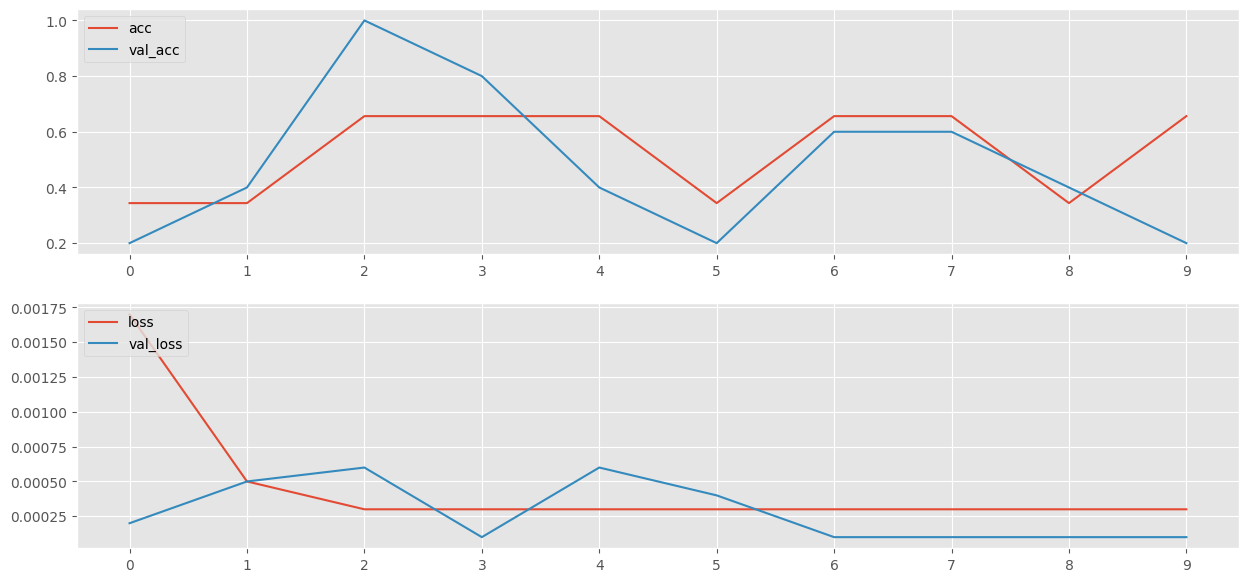

In [83]:
MODEL_NAME = 'model-latest'
create_acc_loss_graph(model_name=MODEL_NAME)

In [85]:
y_test_hat = get_prediction(net=net, X=X_test, y=y_test)
y_test_hat

tensor([-3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05,
        -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05,
        -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05,
        -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05,
        -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05,
        -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05,
        -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05,
        -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05,
        -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05,
        -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05,
        -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05,
        -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05,
        -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5122e-05,
        -3.5122e-05, -3.5122e-05, -3.5122e-05, -3.5